# Evaluating Curriculum Rigor
## Background
In my experience with high school curriculum, I have found a wide variation in the rigor of course material.  This project seeks to develop a tool for evaluating the rigor of a curriculum, by measuring its alignment to the College Board's respective AP Course.  This project focuses on the College Board's AP Computer Science A course, which covers a first year Java and Object Orientied Design course.

For this course, the College Board defines a set of "Computational Thinking Practices" (skills) and content that will be assessed on a year-end summative assessment to determine student's mastery of the course.   

There are 5 main Computational Thinking Practices identified by the College Board, which it then breaks down into subskills:  

<img src="Reports/Images/Skills-List.png" width=600px> 

In addition, the College Board defines a set of "Essential Knowledge" (the content) to be assessed in the course, which it organizes under 5 "Big Ideas."  For example, the content for a lesson on iteration is: 

<img src="Reports/Images/Content-Sample.png" width=400px>

Every question on the College Board's end-of-course summative exam is aligned to a particular computational thinking skill and essential knowledge.  As a note, some school networks have found the College Board's standards to be very complete, and "backwards plan" their middle school and pre-AP high school courses to prepare students for the AP level work. 

As a first step, this project will focus on the assessment questions used in a particular curriculum, and measure how well they align to the College Board's Computational Thinking Practice and Curriculum Framework.  (As a note, AP classes in most subjects have an analagous set of  thinking practices and framework standards, so one day, this work may be generalized to assess curriculums in other subject areas.)

Two questions to assess are:  

1. Can a TF-IDF vectorization of College Board question prompt with a Logistic Regressor successfully classify an assessment question by Computational Thinking Practice?
2. If ChatGPT is supplied only with the College Board Framework for Computational Thinking, can it successfully identify the particular thinking practice being assessed by a question prompt?

### Initial Conclusions:
1. When just classifying between two different computational thinking practices, both the Logistic Regression and ChatGPT classify with 100% accuracy

### Next Steps:
1. Expand this to include all 15 computational thinking practices.  Compare accuracy of Logistic Regression and ChatGPT.
2. Determine whether the classifier can also identify the "Essential Knowledge" assessed by the question, not just the computational skill.
3. Attempt to generalize the classifiers to classify non-assessment questions such as lecture material, lab questions, and homework problems.
4. Create a visualization that shows the distribution of thinking skills and content assessed over the course of the curriculum.

## Classifying Questions Using Logistic Regression
As first step, this section will try to classify prompts as assessing one of these two AP Computational Thinking Practices (CTP):
1. **CTP 2.A**: Apply the meaning of specific operators.  For example:  
*Consider the following code segment.*  
```
int x = 7;  
int y = 3;  
if ((x < 10) && (y < 0))  
  System.out.println(""Value is: "" + x * y);  
else  
  System.out.println(""Value is: "" + x / y) 
```
*What is printed as a result of executing the code segment?*

2. **CTP 2.B**: Determine the results or output based on statement execution order in a code segment without method calls (except for output).  For example:  

*Consider the following code segment.* 
```
int[] arr = {7, 2, 5, 3, 0, 10};  
for (int k = 0; k < arr.length - 1; k++)  {  
  if (arr[k] > arr[k + 1])  
    System.out.print(k + "" "" + arr[k] + "" "");  
} 
``` 
*What will be printed as a result of executing the code segment?*  

## Preprocessing the Data
In this first step, we will:
1. Read in example prompts for each category.
2. Preprocess the data: tokenize, lemmatize, and look at the token frequency distribution by question category.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist

In [72]:
df1 = pd.read_csv("Data/Synthetic/Synthetic2A.csv")
df2 = pd.read_csv("Data/Synthetic/Synthetic2B.csv")
df = pd.concat([df1, df2])

## Testing the Logistic Regression Classifier on the Questions
Here, we build a pipeline that does the following:
1. Preprocess Text: tokenize and lemmatize the text, vectorize using TF-IDF, restricting to 10 features.
2. Train and test a logistic regression classifier.  Evaluate the model appropriately.

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [74]:
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    temp = tokenizer.tokenize(text.lower())
    return [lemmatizer.lemmatize(w) for w in temp]

tfidf = TfidfVectorizer(strip_accents='ascii', tokenizer=lemmatize_text, stop_words="english", max_features=10)

pipeline = [("tfidf",TfidfVectorizer(strip_accents='ascii', tokenizer=lemmatize_text, stop_words="english", max_features=10)),
            ("lr", LogisticRegression())]
pipe = Pipeline(steps=pipeline)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df["Question"], df["Classification"])

pipe.fit(X_train, y_train)

/Users/jgoett/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/jgoett/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10, stop_words='english',
                                 strip_accents='ascii',
                                 tokenizer=<function lemmatize_text at 0x1690558b0>)),
                ('lr', LogisticRegression())])

In [76]:
y_test_pred = pipe.predict(X_test)
print(classification_report(y_test, y_test_pred))
con_mat = confusion_matrix(y_test, y_test_pred)

              precision    recall  f1-score   support

         2.A       1.00      1.00      1.00         1
         2.B       1.00      1.00      1.00         4

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



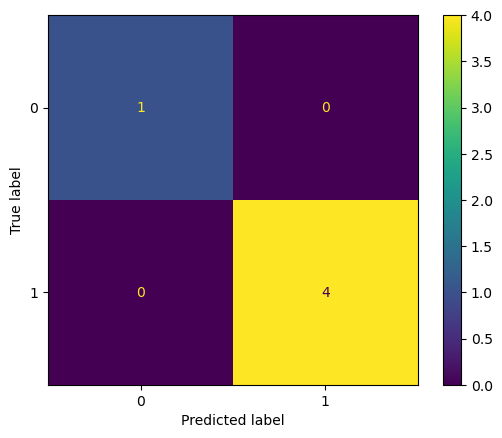

In [77]:
ConfusionMatrixDisplay(con_mat).plot()

## Build and Test a ChatGPT Classifier

This classifier asks ChatGPT to determine the Computational Thinking Skill being assessed in the problem.  
1.  Create a function call to ask ChatGPT for the classification
2.  Test ChatGPT on data set and evaluate classification.

In [71]:
import pandas as pd
from openai import OpenAI
import os

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

df1 = pd.read_csv("Data/Synthetic/Synthetic2A.csv")
df2 = pd.read_csv("Data/Synthetic/Synthetic2B.csv")
df = pd.concat([df1, df2])
df.reset_index(inplace=True)
df["Classification"] = df["Classification"].str.strip(" '")

In [72]:
prompt_start = """
Here are the categories for AP questions. 
2.A: Apply the meaning of specific operators 
2.B: Determine the result or output based on statement execution order in a code segment without method calls (other than output) 

Below are example questions for each of these categories
2.A: Consider  the following  code  segment.  Assume  num is a properly  declared  and initialized  int variable.  if (num  > 0) { if (num  % 2 == 0) { System.out.println( "A"); } else  { System.out.println( "B"); } } Which  of the following  best describes  the result  of executing  the code  segment?  (A) When  num is a negative  odd integer,  "B" is printed;  otherwise,  "A" is printed.  (B) When  num is a negative  even  integer,  "B" is printed;  otherwise,  nothing  is printed.  (C) When  num is a positive  even  integer,  "A" is printed;  otherwise,  "B" is printed.  (D) When  num is a positive  even  integer,  "A" is printed;  when  num is a positive  odd integer,  "B" is printed;  otherwise,  nothing  is printed.
2.B: Consider  the following  code segment.  int[][]  values  = {{1,  2, 3}, {4, 5, 6}};  int x = 0; for (int  j = 0; j < values.length;  j++)  { for (int  k = 0; k < values[0].length;  k++)  { if (k == 0) { values[j][k]  *= 2; } x += values[j][k];  } } What  is the value  of x after the code segment  is executed?  (A) 7 (B) 17 (C) 21 (D) 26

Based on these, classify the following prompt as either 2.A or 2.B.  Please reply with just "2.A" or "2.B"
"""

In [73]:
client = OpenAI(api_key=os.environ.get("jeff_api"))

def gpt_classify(prompt):
  response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[{"role": "user", "content": prompt_start + prompt}]
  )
  return response.choices[0].message.content


In [74]:
df["GPT_Classify"] = df["Question"].apply(gpt_classify)

In [75]:
print(classification_report(df["Classification"], df["GPT_Classify"]));

              precision    recall  f1-score   support

         2.A       1.00      1.00      1.00        10
         2.B       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



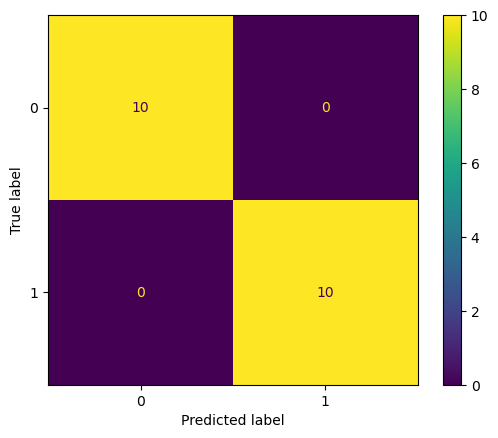

In [76]:
con_mat = confusion_matrix(df["Classification"], df["GPT_Classify"])
ConfusionMatrixDisplay(confusion_matrix=con_mat).plot()

## Summary  
When just looking at two categories of questions, both the Logistic Regression and ChatGPT classifiers classify the computational thinking practice with 100% accuracy.  This should be expanded to incorporate classify questions from all 15 thinking practices.  In addition, it should be trained to classify the content assessed, not just the skill.